In [1]:
library("sp")
library("spacetime")
library("ggplot2")
library("dplyr")
library("gstat")
library("RColorBrewer")
library("STRbook")
library("tidyr")


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
data("STObj3", package = "STRbook")
STObj4 <- STObj3[, "1993-07-01::1993-07-31"]
vv <- variogram(object = z ~ 1 + lat, # fixed effect component
data = STObj4,
# July data
width = 80,
# spatial bin (80 km)
cutoff = 1000,
# consider pts < 1000 km apart
tlags = 0.01:6.01)

Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j):
"converting 'i' to integer because it appears to contain fractions"
Warning message in `[.xts`(x@time, j)

In [5]:
# vignette("spatio-temporal-kriging")

sepVgm <- vgmST(stModel = "separable",
space = vgm(10, "Exp", 400, nugget = 0.1),
time = vgm(10, "Exp", 1, nugget = 0.1),
sill = 20)
sepVgm <- fit.StVariogram(vv, sepVgm)

In [6]:
metricVgm <- vgmST(stModel = "metric",
joint = vgm(100, "Exp", 400, nugget = 0.1),
sill = 10,
stAni = 100)
metricVgm <- fit.StVariogram(vv, metricVgm)

In [7]:
metricMSE <- attr(metricVgm, "optim")$value
sepMSE <- attr(sepVgm, "optim")$value

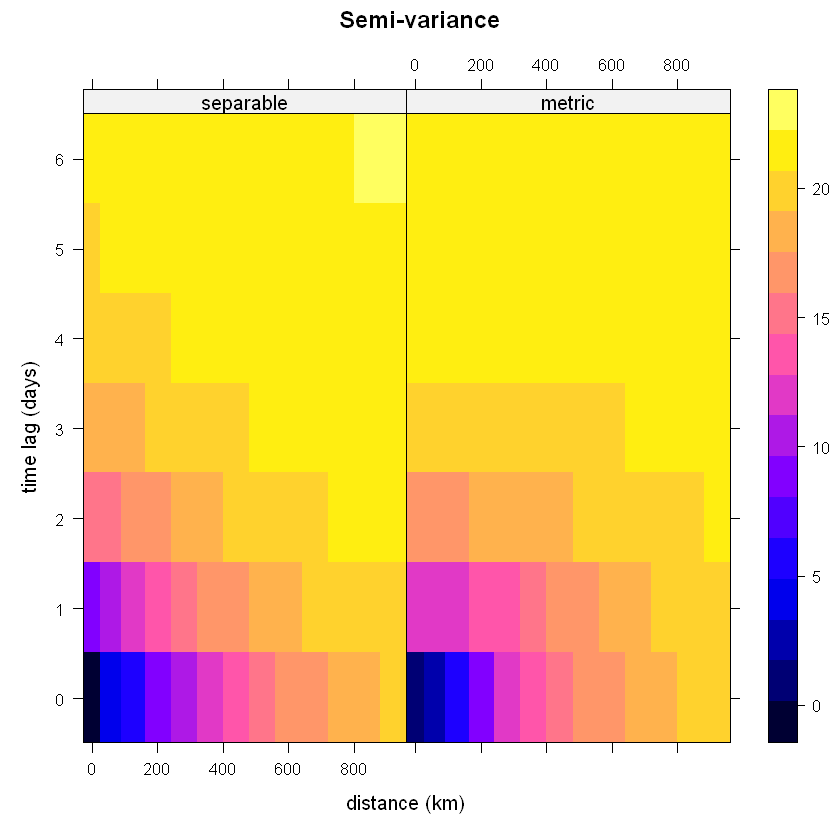

In [8]:
plot(vv, list(sepVgm, metricVgm), main = "Semi-variance")

In [9]:
spat_pred_grid <- expand.grid(
lon = seq(-100, -80, length = 20),
lat = seq(32, 46, length = 20)) %>%
SpatialPoints(proj4string = CRS(proj4string(STObj3)))
gridded(spat_pred_grid) <- TRUE

In [18]:

temp_pred_grid <- as.Date("1993-07-01") + seq(3, 28, length = 6)
# DE_pred <- STF(sp = spat_pred_grid,
# # spatial part
# time = temp_pred_grid)


In [19]:
DE_pred <- STF(sp = spat_pred_grid,
# spatial part
time = temp_pred_grid)
# temporal part

In [20]:
STObj5 <- as(STObj4[, -14], "STIDF")
# convert to STIDF
STObj5 <- subset(STObj5, !is.na(STObj5$z))

In [21]:
pred_kriged <- krigeST(z ~ 1 + lat,
# latitude trend
data = STObj5,
# data set w/o 14 July
newdata = DE_pred,
# prediction grid
modelList = sepVgm,
# semivariogram
computeVar = TRUE)

please verify that the CRSs of data and newdata are identical, or transform them first to make them identical



In [22]:
ls()

[1] "DE_pred"        "metricMSE"      "metricVgm"      "pred_kriged"   
 [5] "sepMSE"         "sepVgm"         "spat_pred_grid" "STObj3"        
 [9] "STObj4"         "STObj5"         "temp_pred_grid" "vv"

In [23]:
color_pal <- rev(colorRampPalette(brewer.pal(11, "Spectral"))(16))

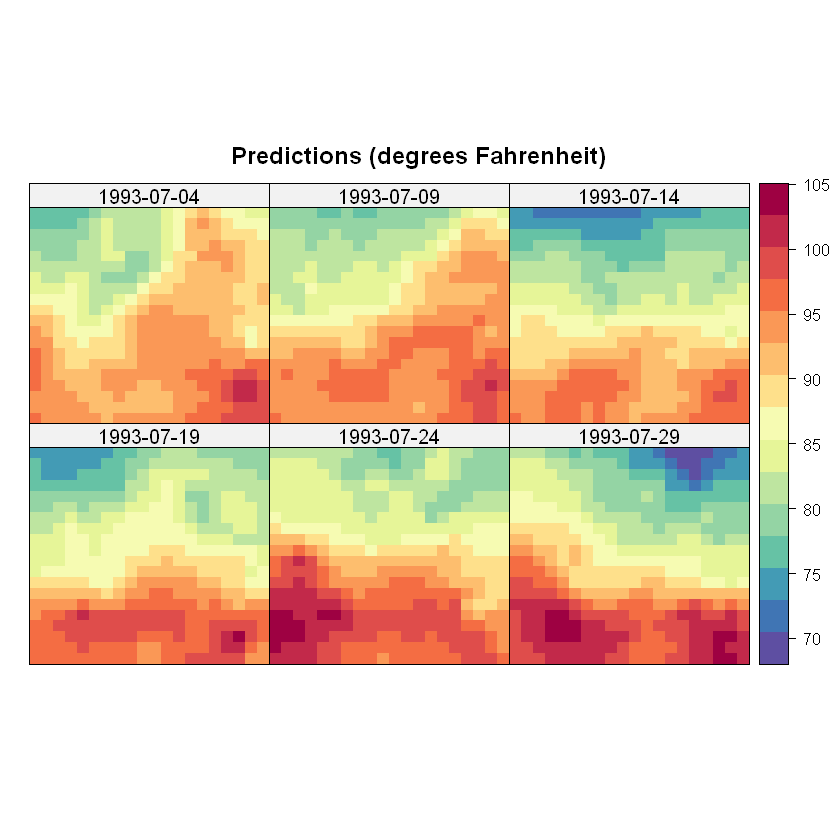

In [24]:
stplot(pred_kriged,
main = "Predictions (degrees Fahrenheit)",
layout = c(3, 2),
col.regions = color_pal)

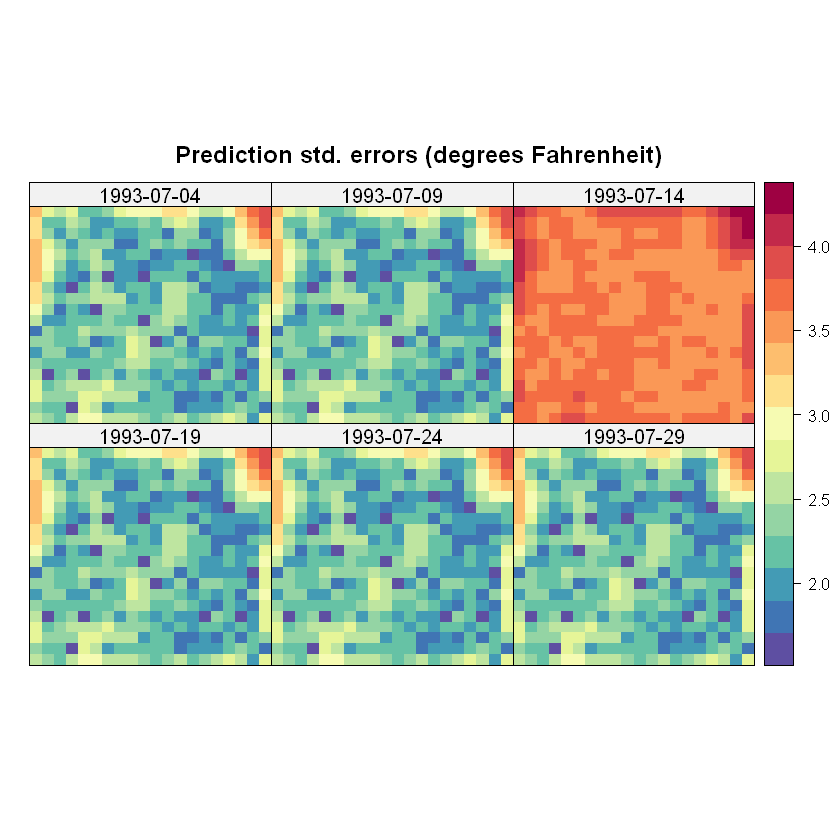

In [25]:
pred_kriged$se <- sqrt(pred_kriged$var1.var)
stplot(pred_kriged[, , "se"],
main = "Prediction std. errors (degrees Fahrenheit)",
layout = c(3, 2),
col.regions = color_pal)